# Integration with finalized model

## Running model

Seed set to 42


✅ Data setup complete


Using 16bit Automatic Mixed Precision (AMP)


✅ Model initialized


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 25 records. Best score: 6048.656. Signaling Trainer to stop.
✅ Training complete


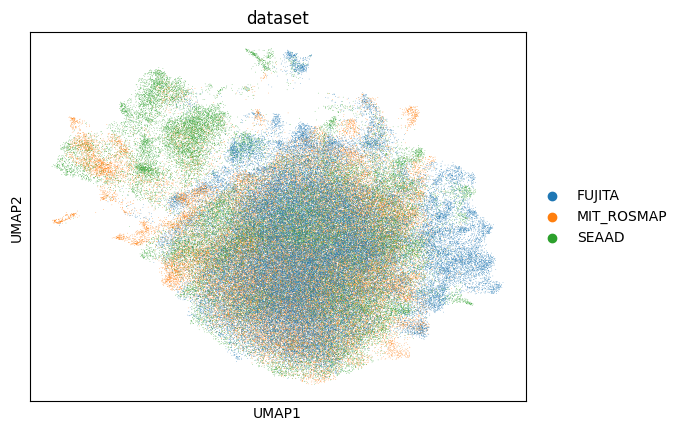

[Silhouette] Global (lower=better): -0.0062
[Silhouette] Mean per cell: -0.0062, Median: 0.0006
[kNN entropy] Mean: 0.6461
[kNN entropy] 25/50/75%: [0.4945082  0.70068046 0.85867271]
✅ Evaluation complete


In [1]:
# Trying a slightly different model 

import scanpy as sc
import scvi
import numpy as np
import torch

# --------------------------------------------------------
# 1. Reproducibility setup
# --------------------------------------------------------
np.random.seed(42)
torch.manual_seed(42)
scvi.settings.seed = 42

# --------------------------------------------------------
# 2. Load and prepare AnnData
# --------------------------------------------------------
adata = sc.read_h5ad("merged_microglia_fixed.h5ad")
scvi.model.SCVI.setup_anndata(adata, batch_key="dataset")
print("✅ Data setup complete")

# --------------------------------------------------------
# 3. Define model (slightly stronger regularization)
# --------------------------------------------------------
best_model = scvi.model.SCVI(
    adata,
    n_hidden=512,           # same size that worked best
    n_layers=3,             # deeper than the v4 model
    n_latent=32,            # same latent dimension
    dropout_rate=0.17,      # slightly higher (was 0.13)
    gene_likelihood="nb"
)
print("✅ Model initialized")

# --------------------------------------------------------
# 4. Train model with slightly shorter KL warmup
# --------------------------------------------------------
best_model.train(
    max_epochs=200,          # enough for early stopping to trigger
    batch_size=256,
    plan_kwargs={
        "lr": 0.0027,        # similar learning rate to your v5 model
        "n_epochs_kl_warmup": 12  # slightly earlier alignment (was 20)
    },
    datasplitter_kwargs={"num_workers": 8},
    accelerator="gpu",
    devices=1,
    precision="16-mixed",
    early_stopping=True,
    early_stopping_patience=25
)
print("✅ Training complete")

# --------------------------------------------------------
# 6. UMAP visualization
# --------------------------------------------------------
adata.obsm["X_scvi"] = best_model.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scvi")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["dataset"])

# --------------------------------------------------------
# 7. Evaluate integration quality (batch metrics)
# --------------------------------------------------------
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors import NearestNeighbors
from scipy.stats import entropy

X = adata.obsm["X_scvi"]
batches = adata.obs["dataset"].astype(str).values

# Silhouette
batch_sil_global = silhouette_score(X, batches, metric="euclidean")
batch_sil_percell = silhouette_samples(X, batches, metric="euclidean")

print(f"[Silhouette] Global (lower=better): {batch_sil_global:.4f}")
print(f"[Silhouette] Mean per cell: {batch_sil_percell.mean():.4f}, "
      f"Median: {np.median(batch_sil_percell):.4f}")

# kNN entropy
batches_cat = adata.obs["dataset"].astype("category")
batch_codes = batches_cat.cat.codes.values
n_batches = batches_cat.cat.categories.size
k = 30

nbrs = NearestNeighbors(n_neighbors=k+1, n_jobs=8).fit(X)
indices = nbrs.kneighbors(return_distance=False)[:, 1:]

entropies = []
for neigh in indices:
    counts = np.bincount(batch_codes[neigh], minlength=n_batches)
    probs = counts / counts.sum()
    ent = entropy(probs) / np.log(n_batches)
    entropies.append(ent)
entropies = np.array(entropies)

print(f"[kNN entropy] Mean: {entropies.mean():.4f}")
print(f"[kNN entropy] 25/50/75%: {np.percentile(entropies, [25,50,75])}")
print("✅ Evaluation complete")


In [2]:
# --------------------------------------------------------
# 5. Save trained model + latent representation
# --------------------------------------------------------
best_model.save("best_model_final_regularized", overwrite=True)
adata.obsm["X_scvi"] = best_model.get_latent_representation()
adata.write("adata_final_regularized.h5ad")
print("✅ Model + AnnData saved")


✅ Model + AnnData saved


/tmp/ipykernel_26126/188291472.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=0.5, key_added="leiden_scvi")
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


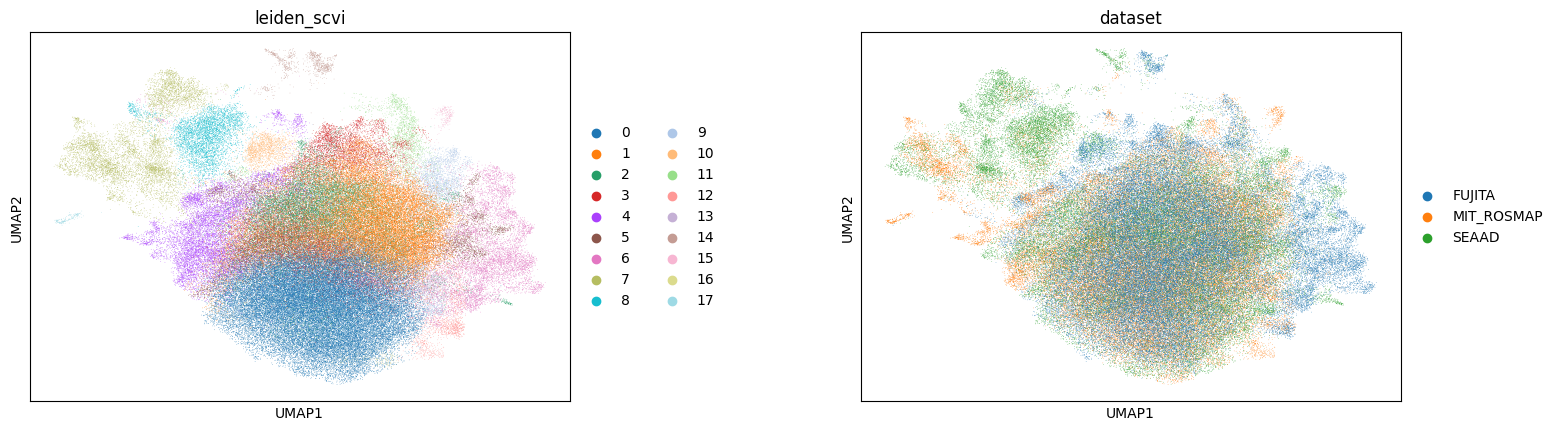

In [3]:
# Make sure we’re using your SCVI embedding
sc.pp.neighbors(adata, use_rep="X_scvi")
sc.tl.leiden(adata, resolution=0.5, key_added="leiden_scvi")

# UMAP colored by cluster and dataset
sc.tl.umap(adata)
sc.pl.umap(adata, color=["leiden_scvi", "dataset"], wspace=0.4)


## Checks of integration and plottin

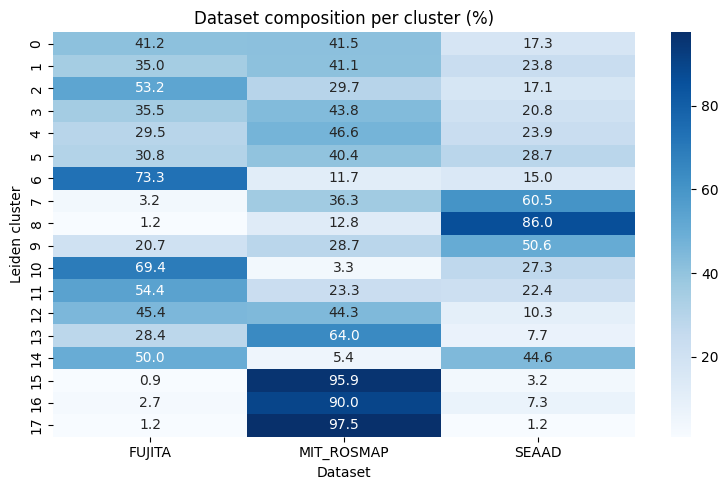

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ct = pd.crosstab(adata.obs["leiden_scvi"], adata.obs["dataset"], normalize="index") * 100

plt.figure(figsize=(8, 5))
sns.heatmap(ct, annot=True, fmt=".1f", cmap="Blues")
plt.title("Dataset composition per cluster (%)")
plt.xlabel("Dataset")
plt.ylabel("Leiden cluster")
plt.tight_layout()
plt.show()


Dataset-biased clusters: ['6', '8', '15', '16', '17']


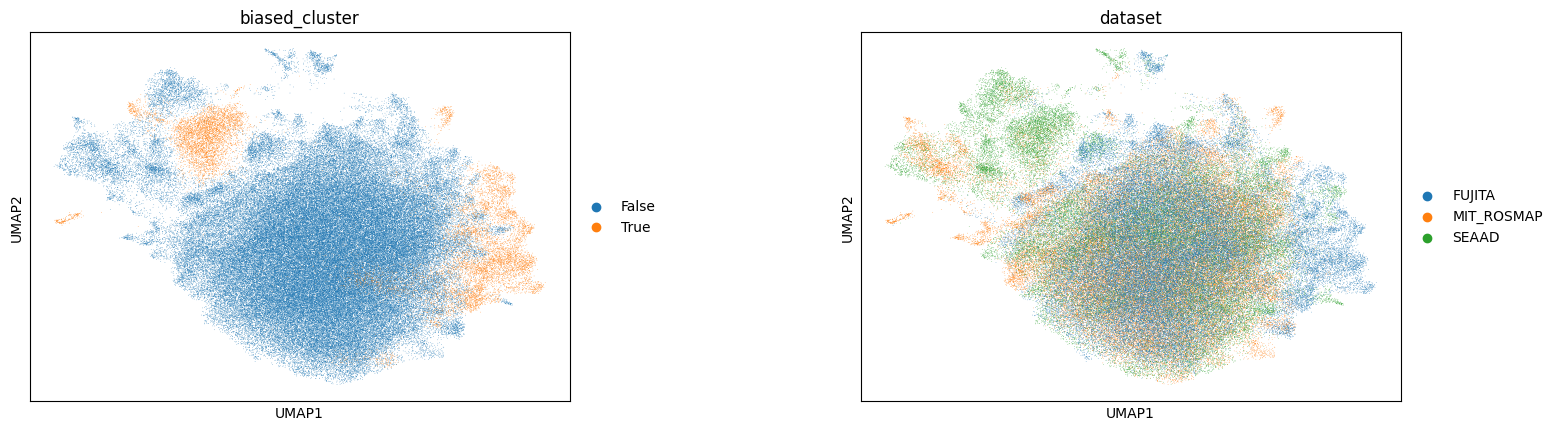

In [9]:
biased_clusters = ct[(ct.max(axis=1) > 70)].index.tolist()  # clusters >70% from one dataset
print("Dataset-biased clusters:", biased_clusters)

adata.obs["biased_cluster"] = adata.obs["leiden_scvi"].isin(biased_clusters)
sc.pl.umap(adata, color=["biased_cluster", "dataset"], wspace=0.4)


/tmp/ipykernel_26126/684858021.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for cl, sub in adata.obs.groupby("leiden_scvi"):


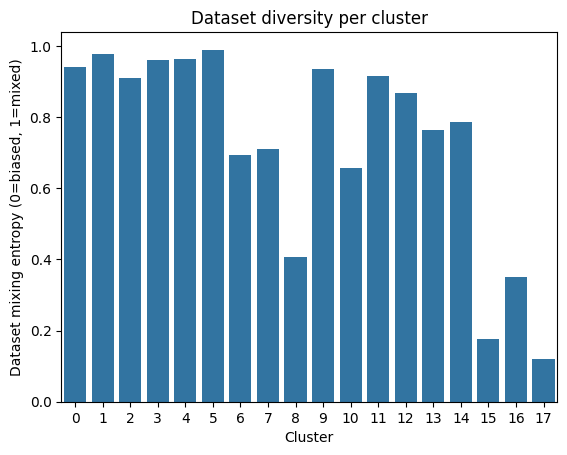

In [10]:
from scipy.stats import entropy

entropy_per_cluster = []
for cl, sub in adata.obs.groupby("leiden_scvi"):
    counts = sub["dataset"].value_counts(normalize=True)
    ent = entropy(counts) / np.log(len(counts))  # normalized [0,1]
    entropy_per_cluster.append((cl, ent))

entropy_df = pd.DataFrame(entropy_per_cluster, columns=["cluster", "normalized_entropy"]).set_index("cluster")

sns.barplot(x=entropy_df.index, y="normalized_entropy", data=entropy_df)
plt.ylabel("Dataset mixing entropy (0=biased, 1=mixed)")
plt.xlabel("Cluster")
plt.title("Dataset diversity per cluster")
plt.show()


In [11]:
# 2. Covariates to visualize
meta_vars = ["pct_counts_mt", "pct_counts_rb", "sex", "age_death", "cogdx", "dataset", "braak_label", "cerad_score_1_4", "apoe_genotype_std" ]
meta_vars = [v for v in meta_vars if v in adata.obs.columns]
print("🖼️ Covariates found:", meta_vars)

# ------------------------------------------------------------
# 3. Plot each covariate + Leiden side-by-side
# ------------------------------------------------------------
for cov in meta_vars:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # --- Left: covariate ---
    sc.pl.umap(
        adata,
        color=cov,
        ax=axes[0],
        show=False,
        color_map="viridis",
        na_color="lightgrey",
        title=f"{cov}",
        size=8,
    )
    
    # --- Right: Leiden clusters ---
    sc.pl.umap(
        adata,
        color="leiden_scvi",
        ax=axes[1],
        show=False,
        legend_loc="on data",
        title="Leiden clusters",
        palette="tab20",
        size=8,
    )
    
    plt.tight_layout()
    plt.savefig(f"umap_{cov}_vs_leiden.png", dpi=300, bbox_inches="tight")
    plt.close(fig)

print("✅ Saved all covariate + Leiden comparison UMAPs")


🖼️ Covariates found: ['pct_counts_mt', 'sex', 'age_death', 'cogdx', 'dataset', 'braak_label', 'cerad_score_1_4', 'apoe_genotype_std']
✅ Saved all covariate + Leiden comparison UMAPs


In [14]:
from sklearn.decomposition import PCA
from scipy.stats import spearmanr

# ------------------------------------------------------------
print("\n📊 Estimating variance explained in SCVI latent space...")

latent = adata.obsm["X_scvi"]
meta = adata.obs[meta_vars].copy()

# convert categorical variables to numeric codes
for c in meta.select_dtypes(include="category").columns:
    meta[c] = meta[c].cat.codes
for c in meta.select_dtypes(include="object").columns:
    meta[c] = meta[c].astype("category").cat.codes

# perform PCA to get latent PCs for stability
pca = PCA(n_components=min(30, latent.shape[1]))
latent_pcs = pca.fit_transform(latent)

var_explained = {}
for cov in meta_vars:
    if cov not in meta.columns:
        continue
    cov_values = meta[cov].values
    # compute mean absolute Spearman correlation across PCs
    rhos = [abs(spearmanr(latent_pcs[:, i], cov_values)[0]) for i in range(latent_pcs.shape[1])]
    var_explained[cov] = np.nanmean(rhos)

var_series = pd.Series(var_explained).sort_values(ascending=False)
print("\nFractional correlation (mean |rho| across latent PCs):")
print(var_series.round(3))

# plot bar chart
plt.figure(figsize=(6, 3))
sns.barplot(x=var_series.index, y=var_series.values, palette="viridis")
plt.ylabel("Mean |Spearman ρ| (covariate ↔ latent PCs)")
plt.xticks(rotation=45, ha="right")
plt.title("Covariate influence on SCVI latent space")
plt.tight_layout()
plt.savefig("covariate_variance_explained.png", dpi=300, bbox_inches="tight")
plt.close()
print("✅ Saved variance explained plot")

print("\n🎯 Done! Check generated PNGs in your working directory.")



📊 Estimating variance explained in SCVI latent space...

Fractional correlation (mean |rho| across latent PCs):
pct_counts_mt        0.092
dataset              0.061
cogdx                0.053
braak_label          0.048
sex                  0.038
age_death            0.036
cerad_score_1_4      0.033
apoe_genotype_std    0.023
dtype: float64


/tmp/ipykernel_26126/131286094.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=var_series.index, y=var_series.values, palette="viridis")


✅ Saved variance explained plot

🎯 Done! Check generated PNGs in your working directory.


In [16]:
import os
# ------------------------------------------------------------
# 3. Create one UMAP per dataset, colored by Leiden cluster
# ------------------------------------------------------------
datasets = adata.obs["dataset"].unique().tolist()
outdir = "umaps_by_dataset"
os.makedirs(outdir, exist_ok=True)

for ds in datasets:
    adata_sub = adata[adata.obs["dataset"] == ds].copy()
    print(f"Plotting dataset: {ds} ({adata_sub.n_obs} cells)")

    fig = sc.pl.umap(
        adata_sub,
        color="leiden_scvi",
        palette="tab20",
        size=15,
        title=f"Dataset: {ds}",
        legend_loc="on data",
        show=False,
        frameon=False,
    )
    plt.savefig(os.path.join(outdir, f"umap_{ds}_by_cluster.png"),
                dpi=300, bbox_inches="tight")
    plt.close()

print(f"✅ Saved one UMAP per dataset in folder: {outdir}")

# ------------------------------------------------------------
# 4. (Optional) Grid plot of all datasets together
# ------------------------------------------------------------
ncols = 3
nrows = int(np.ceil(len(datasets) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))

for i, ds in enumerate(datasets):
    ax = axes.flatten()[i]
    adata_sub = adata[adata.obs["dataset"] == ds].copy()
    sc.pl.umap(
        adata_sub,
        color="leiden_scvi",
        palette="tab20",
        size=10,
        title=ds,
        legend_loc=None,
        show=False,
        ax=ax,
        frameon=False,
    )

# hide empty subplots if any
for j in range(i+1, len(axes.flatten())):
    axes.flatten()[j].axis("off")

plt.tight_layout()
plt.savefig("umap_by_dataset_grid.png", dpi=300, bbox_inches="tight")
plt.close()
print("✅ Saved grid figure: umap_by_dataset_grid.png")


Plotting dataset: MIT_ROSMAP (57452 cells)
Plotting dataset: SEAAD (38103 cells)
Plotting dataset: FUJITA (58593 cells)
✅ Saved one UMAP per dataset in folder: umaps_by_dataset
✅ Saved grid figure: umap_by_dataset_grid.png


In [17]:
# ------------------------------------------------------------
# 2. Compute per-cell kNN entropy if not present
# ------------------------------------------------------------
if "knn_entropy" not in adata.obs.columns:
    print("🔹 Computing kNN entropy per cell...")
    X = adata.obsm["X_scvi"]
    batches = adata.obs["dataset"].astype("category")
    batch_codes = batches.cat.codes.values
    n_batches = batches.cat.categories.size

    k = 30  # number of nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=k+1, n_jobs=8).fit(X)
    indices = nbrs.kneighbors(return_distance=False)[:, 1:]  # drop self

    entropies = []
    for neigh in indices:
        counts = np.bincount(batch_codes[neigh], minlength=n_batches)
        probs = counts / counts.sum()
        ent = entropy(probs) / np.log(n_batches)  # normalize to [0,1]
        entropies.append(ent)

    adata.obs["knn_entropy"] = entropies
    adata.write("adata_final_regularized_with_entropy.h5ad")
    print("✅ Stored 'knn_entropy' in adata.obs and saved new file")
else:
    print("✅ 'knn_entropy' already exists in adata.obs")

# ------------------------------------------------------------
# 3. Ensure Leiden clustering exists
# ------------------------------------------------------------
if "leiden_scvi" not in adata.obs.columns:
    sc.tl.leiden(adata, resolution=0.5, key_added="leiden_scvi", flavor="igraph", n_iterations=2, directed=False)
    print("🔹 Added Leiden clustering")

# ------------------------------------------------------------
# 4. Compute mean entropy per cluster and find low-entropy clusters
# ------------------------------------------------------------
entropy_per_cluster = adata.obs.groupby("leiden_scvi")["knn_entropy"].mean().sort_values()
biased_clusters = entropy_per_cluster[entropy_per_cluster < 0.6].index.tolist()

print("\n🧠 Mean entropy per cluster:")
print(entropy_per_cluster.round(3))
print("\n⚠️ Clusters with mean entropy < 0.6:", biased_clusters)
# ------------------------------------------------------------
# Save entropy per cluster to CSV
# ------------------------------------------------------------
entropy_per_cluster_df = (
    adata.obs
    .groupby("leiden_scvi")
    .agg(mean_knn_entropy=("knn_entropy", "mean"),
         n_cells=("knn_entropy", "size"))
    .sort_values("mean_knn_entropy")
    .reset_index()
)
entropy_per_cluster_df.to_csv("entropy_per_cluster.csv", index=False)
print("✅ Saved: entropy_per_cluster.csv (includes cell counts)")

# ------------------------------------------------------------
# 5. Covariates to test
# ------------------------------------------------------------
covariates = [
    "pct_counts_mt", "sex", "age_death", "cogdx",
    "dataset", "braak_label", "cerad_score_1_4", "apoe_genotype_std"
]
covariates = [c for c in covariates if c in adata.obs.columns]
print("🔍 Covariates found:", covariates)

# ------------------------------------------------------------
# 6. Numeric covariate summary heatmap (final robust version)
# ------------------------------------------------------------
numeric_covs = [
    c for c in covariates
    if c in adata.obs.columns and pd.api.types.is_numeric_dtype(adata.obs[c])
]

if numeric_covs and len(biased_clusters) > 0:
    # Compute mean of numeric covariates per cluster
    mean_table = adata.obs.groupby("leiden_scvi", observed=True)[numeric_covs].mean()
    mean_table = mean_table.loc[biased_clusters]

    # Convert all data to proper float64 to avoid plotting errors
    mean_table = mean_table.apply(pd.to_numeric, errors="coerce").astype(float)

    # Drop rows/cols that are all NaN
    mean_table = mean_table.dropna(axis=0, how="all")
    mean_table = mean_table.dropna(axis=1, how="all")

    print("\nMean table dtypes:")
    print(mean_table.dtypes)
    print("\nPreview of numeric covariate means:")
    print(mean_table.head())

    if mean_table.shape[1] > 0:
        plt.figure(figsize=(max(6, 1.5 * mean_table.shape[1]), 4))
        sns.heatmap(
            mean_table,
            cmap="vlag",
            center=np.nanmean(mean_table.values),
            annot=True,
            fmt=".2f"
        )
        plt.title("Mean numeric covariate values in low-entropy clusters")
        plt.tight_layout()
        plt.savefig("biased_clusters_mean_covariates.png",
                    dpi=300, bbox_inches="tight")
        plt.close()
        print("✅ Saved: biased_clusters_mean_covariates.png")
    else:
        print("⚠️ No valid numeric covariates left for plotting.")
else:
    print("⚠️ No numeric covariates or biased clusters available for heatmap.")


# ------------------------------------------------------------
# 7. Visualizations: p-value heatmap and covariate summary
# ------------------------------------------------------------

# ---- 7A. Heatmap of adjusted p-values (force all clusters to display) ----
import numpy as np
from matplotlib.colors import Normalize
from matplotlib import cm

plt.figure(figsize=(12, 6))

# --- Get full cluster list directly from AnnData ---
all_clusters = sorted([str(x) for x in adata.obs["leiden_scvi"].unique()])
all_covariates = sorted(results_df["covariate"].unique())

# --- Build full pivot table ---
pivot = results_df.pivot_table(
    index="cluster",
    columns="covariate",
    values="p_adj",
    aggfunc="min",
    observed=True
)

# --- Ensure both cluster and covariate labels match types ---
pivot.index = pivot.index.astype(str)
pivot.columns = pivot.columns.astype(str)

# --- Reindex to include *all* clusters (even if missing) ---
pivot = pivot.reindex(index=all_clusters, columns=all_covariates)

# --- Fill NaNs so seaborn renders them ---
pivot_for_color = pivot.fillna(1.0)  # color = light gray
annot_data = pivot.applymap(lambda x: f"{x:.3f}" if pd.notnull(x) else "–")

# --- Draw heatmap ---
ax = sns.heatmap(
    pivot_for_color,
    cmap="mako_r",
    cbar_kws={"label": "Adjusted p-value"},
    vmin=0, vmax=1.0,
    annot=False,
    linewidths=0.3,
    linecolor="gray"
)

# --- Annotate every cell with dynamic text color ---
norm = Normalize(vmin=0, vmax=1.0)
cmap = cm.get_cmap("mako_r")
for i in range(pivot.shape[0]):
    for j in range(pivot.shape[1]):
        val = pivot_for_color.iloc[i, j]
        label = annot_data.iloc[i, j]
        rgba = cmap(norm(val))
        brightness = 0.299*rgba[0] + 0.587*rgba[1] + 0.114*rgba[2]
        text_color = "black" if brightness > 0.6 else "white"
        ax.text(
            j + 0.5,
            i + 0.5,
            label,
            ha="center",
            va="center",
            color=text_color,
            fontsize=8,
            fontweight="bold"
        )

plt.title("Cluster–Covariate Associations (all clusters, all p-values)")
plt.xlabel("Covariates")
plt.ylabel("Leiden clusters")
plt.tight_layout()
plt.savefig("biased_clusters_covariate_heatmap_allclusters_force_all.png",
            dpi=300, bbox_inches="tight")
plt.close()

print("✅ Saved: biased_clusters_covariate_heatmap_allclusters_force_all.png")

# ---- 7B. (Optional) Re-plot numeric means for reference ----
if numeric_covs and len(biased_clusters) > 0:
    mean_table = adata.obs.groupby("leiden_scvi", observed=True)[numeric_covs].mean()
    mean_table = mean_table.loc[biased_clusters]
    mean_table = mean_table.apply(pd.to_numeric, errors="coerce").astype(float)

    plt.figure(figsize=(max(6, 1.5 * mean_table.shape[1]), 4))
    sns.heatmap(
        mean_table,
        cmap="vlag",
        center=np.nanmean(mean_table.values),
        annot=True,
        fmt=".2f"
    )
    plt.title("Mean numeric covariate values in low-entropy clusters")
    plt.tight_layout()
    plt.savefig("biased_clusters_mean_covariates.png",
                dpi=300, bbox_inches="tight")
    plt.close()
    print("✅ Re-saved: biased_clusters_mean_covariates.png")

print("\n🎯 Done! Outputs generated:")
print(" - 'biased_clusters_covariate_heatmap.png' → p-value overview")
print(" - 'biased_clusters_mean_covariates.png' → mean covariate levels per low-entropy cluster")
print(" - 'significant_cluster_covariate_associations.csv' → full results table")


🔹 Computing kNN entropy per cell...
✅ Stored 'knn_entropy' in adata.obs and saved new file

🧠 Mean entropy per cluster:
leiden_scvi
17    0.018
15    0.139
14    0.290
7     0.333
8     0.444
6     0.480
16    0.497
10    0.542
12    0.606
13    0.608
4     0.612
9     0.638
5     0.660
3     0.684
2     0.692
0     0.697
1     0.719
11    0.725
Name: knn_entropy, dtype: float64

⚠️ Clusters with mean entropy < 0.6: ['17', '15', '14', '7', '8', '6', '16', '10']
🔍 Covariates found: ['pct_counts_mt', 'sex', 'age_death', 'cogdx', 'dataset', 'braak_label', 'cerad_score_1_4', 'apoe_genotype_std']

Mean table dtypes:
pct_counts_mt      float64
age_death          float64
cerad_score_1_4    float64
dtype: object

Preview of numeric covariate means:
             pct_counts_mt  age_death  cerad_score_1_4
leiden_scvi                                           
17                1.959924  87.571547         2.453988
15                0.540253  79.035944         2.022727
14                1.039371  8

/tmp/ipykernel_26126/1548675878.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  entropy_per_cluster = adata.obs.groupby("leiden_scvi")["knn_entropy"].mean().sort_values()


✅ Saved: biased_clusters_mean_covariates.png


NameError: name 'results_df' is not defined

<Figure size 1200x600 with 0 Axes>

In [18]:
# ------------------------------------------------------------
# 2. Prepare covariates
# ------------------------------------------------------------
covariates = [ "total_counts",
    "pct_counts_mt", "sex", "age_death", "cogdx",
    "dataset", "braak_label", "cerad_score_1_4", "apoe_genotype_std"
]
covariates = [c for c in covariates if c in adata.obs.columns]
print("🔍 Covariates found:", covariates)

# ------------------------------------------------------------
# 3. Compute per-cell correlation proxies
# ------------------------------------------------------------
# Convert cluster to dummy variables (one-hot encoding)
cluster_dummies = pd.get_dummies(adata.obs["leiden_scvi"], prefix="cluster").astype(int)

# Create combined dataframe for correlation analysis
df = pd.concat([cluster_dummies, adata.obs[covariates].copy()], axis=1)

# Encode categorical covariates as integers
for cov in covariates:
    if df[cov].dtype.name == "category" or df[cov].dtype == object:
        df[cov] = df[cov].astype("category").cat.codes

# ------------------------------------------------------------
# 4. Define helper: Cramer's V for categorical covariates
# ------------------------------------------------------------
def cramers_v(x, y):
    """Compute Cramer's V (effect size for categorical association)."""
    confusion = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion)[0]
    n = confusion.sum().sum()
    phi2 = chi2 / n
    r, k = confusion.shape
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# ------------------------------------------------------------
# 5. Compute correlations (Spearman for numeric, Cramer's V for categorical)
# ------------------------------------------------------------
corr_matrix = pd.DataFrame(index=cluster_dummies.columns, columns=covariates, dtype=float)

for cov in covariates:
    col = df[cov]
    if pd.api.types.is_numeric_dtype(col):
        # Spearman correlation per cluster dummy
        for cluster_col in cluster_dummies.columns:
            rho, _ = spearmanr(df[cluster_col], col)
            corr_matrix.loc[cluster_col, cov] = rho
    else:
        # Cramer's V for categorical covariates
        for cluster_col in cluster_dummies.columns:
            corr_matrix.loc[cluster_col, cov] = cramers_v(df[cluster_col], col)

corr_matrix = corr_matrix.astype(float)

# ------------------------------------------------------------
# 6. Visualize correlation matrix
# ------------------------------------------------------------
plt.figure(figsize=(12, 6))
sns.heatmap(
    corr_matrix,
    cmap="vlag",
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.3,
    cbar_kws={"label": "Correlation (Spearman or Cramér's V)"}
)
plt.title("Correlation of Leiden clusters with covariates")
plt.xlabel("Covariates")
plt.ylabel("Leiden cluster")
plt.tight_layout()
plt.savefig("cluster_covariate_correlation_heatmap.png", dpi=300, bbox_inches="tight")
plt.close()

print("✅ Saved: cluster_covariate_correlation_heatmap.png")

plt.figure(figsize=(12, 6))
sns.heatmap(
    corr_matrix,
    cmap="vlag",
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.3,
    cbar_kws={"label": "Correlation (Spearman or Cramér's V)"}
)
plt.title("Correlation of Leiden clusters with covariates")
plt.xlabel("Covariates")
plt.ylabel("Leiden cluster")

# ✅ Rotate column (x-axis) labels
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig("cluster_covariate_correlation_heatmap_rotated.png", dpi=300, bbox_inches="tight")
plt.close()

print("✅ Saved: cluster_covariate_correlation_heatmap_rotated.png")



🔍 Covariates found: ['total_counts', 'pct_counts_mt', 'sex', 'age_death', 'cogdx', 'dataset', 'braak_label', 'cerad_score_1_4', 'apoe_genotype_std']
✅ Saved: cluster_covariate_correlation_heatmap.png
✅ Saved: cluster_covariate_correlation_heatmap_rotated.png


# Try removing MT and RB genes

Seed set to 42


✅ Removed 13 mitochondrial and 99 ribosomal genes
✅ Data setup complete


Using 16bit Automatic Mixed Precision (AMP)


✅ Model initialized


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training:   0%|          | 0/200 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 25 records. Best score: 5964.493. Signaling Trainer to stop.
✅ Training complete


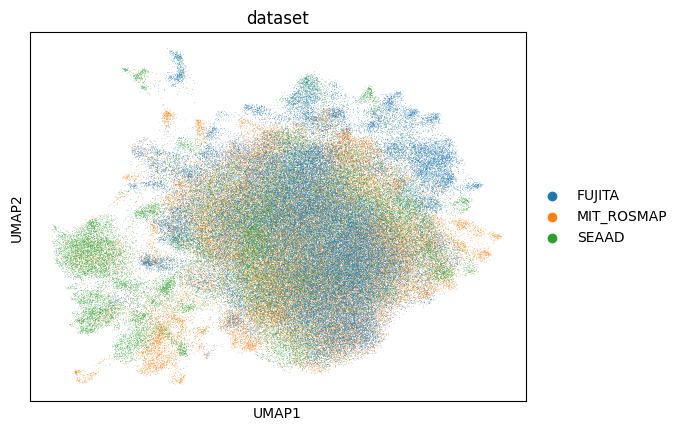

[Silhouette] Global (lower=better): -0.0081
[Silhouette] Mean per cell: -0.0081, Median: -0.0019
[kNN entropy] Mean: 0.6497
[kNN entropy] 25/50/75%: [0.51221876 0.71703736 0.85989296]
✅ Evaluation complete


In [19]:
import scanpy as sc
import scvi
import numpy as np
import torch

# --------------------------------------------------------
# 1. Reproducibility setup
# --------------------------------------------------------
np.random.seed(42)
torch.manual_seed(42)
scvi.settings.seed = 42

# --------------------------------------------------------
# 2. Load and prepare AnnData
# --------------------------------------------------------
adata = sc.read_h5ad("merged_microglia_fixed.h5ad")

# Identify mitochondrial and ribosomal genes
mt_genes = adata.var_names.str.startswith(("MT-", "mt-"))
rb_genes = adata.var_names.str.startswith(("RPS", "RPL"))

# Filter out these genes
adata = adata[:, ~(mt_genes | rb_genes)].copy()
print(f"✅ Removed {mt_genes.sum()} mitochondrial and {rb_genes.sum()} ribosomal genes")

# Setup SCVI
scvi.model.SCVI.setup_anndata(adata, batch_key="dataset")
print("✅ Data setup complete")

# --------------------------------------------------------
# 3. Define model (slightly stronger regularization)
# --------------------------------------------------------
best_model = scvi.model.SCVI(
    adata,
    n_hidden=512,
    n_layers=3,
    n_latent=32,
    dropout_rate=0.17,
    gene_likelihood="nb"
)
print("✅ Model initialized")

# --------------------------------------------------------
# 4. Train model with shorter KL warmup
# --------------------------------------------------------
best_model.train(
    max_epochs=200,
    batch_size=256,
    plan_kwargs={
        "lr": 0.0027,
        "n_epochs_kl_warmup": 12
    },
    datasplitter_kwargs={"num_workers": 8},
    accelerator="gpu",
    devices=1,
    precision="16-mixed",
    early_stopping=True,
    early_stopping_patience=25
)
print("✅ Training complete")

# --------------------------------------------------------
# 5. UMAP visualization
# --------------------------------------------------------
adata.obsm["X_scvi"] = best_model.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scvi")
sc.tl.umap(adata)
sc.pl.umap(adata, color=["dataset"])

# --------------------------------------------------------
# 6. Evaluate integration quality
# --------------------------------------------------------
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors import NearestNeighbors
from scipy.stats import entropy

X = adata.obsm["X_scvi"]
batches = adata.obs["dataset"].astype(str).values

# Silhouette
batch_sil_global = silhouette_score(X, batches, metric="euclidean")
batch_sil_percell = silhouette_samples(X, batches, metric="euclidean")

print(f"[Silhouette] Global (lower=better): {batch_sil_global:.4f}")
print(f"[Silhouette] Mean per cell: {batch_sil_percell.mean():.4f}, "
      f"Median: {np.median(batch_sil_percell):.4f}")

# kNN entropy
batches_cat = adata.obs["dataset"].astype("category")
batch_codes = batches_cat.cat.codes.values
n_batches = batches_cat.cat.categories.size
k = 30

nbrs = NearestNeighbors(n_neighbors=k+1, n_jobs=8).fit(X)
indices = nbrs.kneighbors(return_distance=False)[:, 1:]

entropies = []
for neigh in indices:
    counts = np.bincount(batch_codes[neigh], minlength=n_batches)
    probs = counts / counts.sum()
    ent = entropy(probs) / np.log(n_batches)
    entropies.append(ent)
entropies = np.array(entropies)

print(f"[kNN entropy] Mean: {entropies.mean():.4f}")
print(f"[kNN entropy] 25/50/75%: {np.percentile(entropies, [25,50,75])}")
print("✅ Evaluation complete")


## Plot checks

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


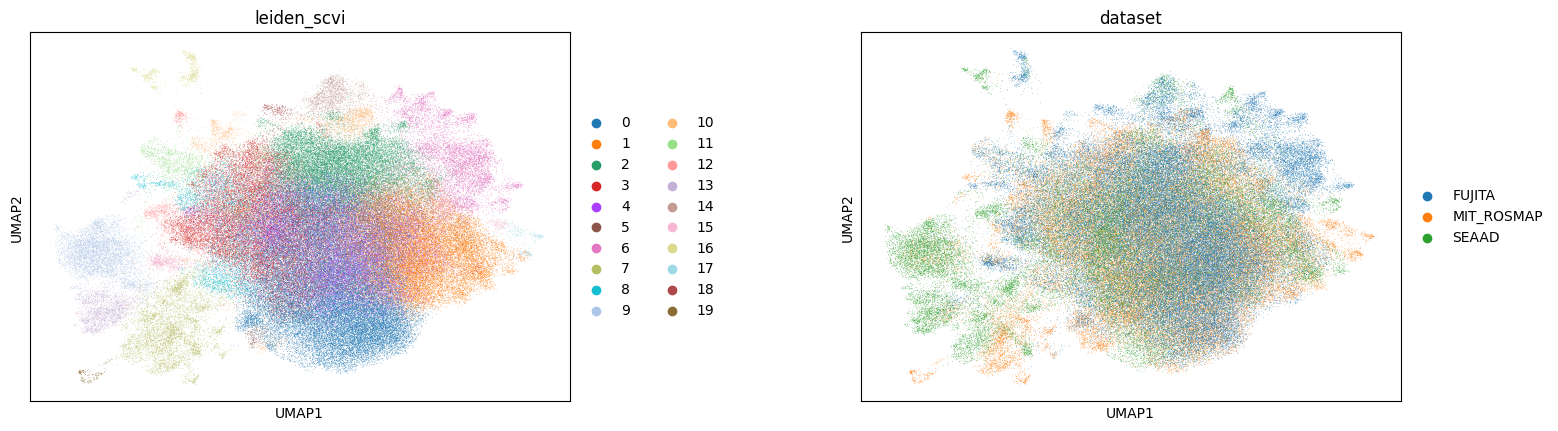

In [21]:
adata.obsm["X_scvi"] = best_model.get_latent_representation()
sc.pp.neighbors(adata, use_rep="X_scvi")
sc.tl.leiden(adata, resolution=0.5, key_added="leiden_scvi")

# UMAP colored by cluster and dataset
sc.tl.umap(adata)
sc.pl.umap(adata, color=["leiden_scvi", "dataset"], wspace=0.4)


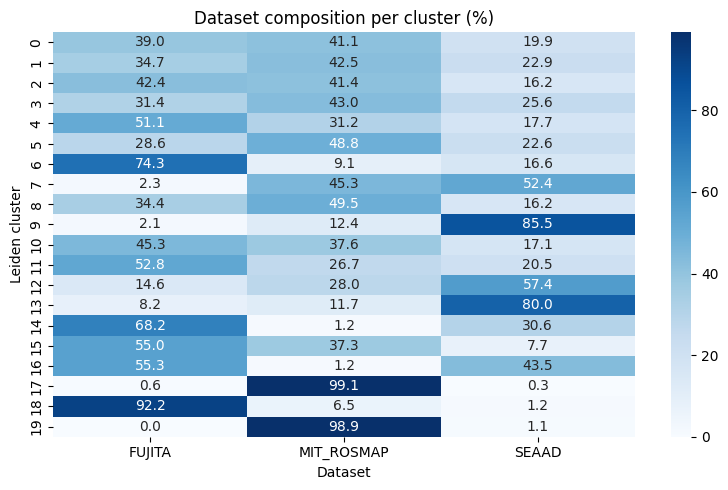

Dataset-biased clusters: ['6', '9', '13', '17', '18', '19']


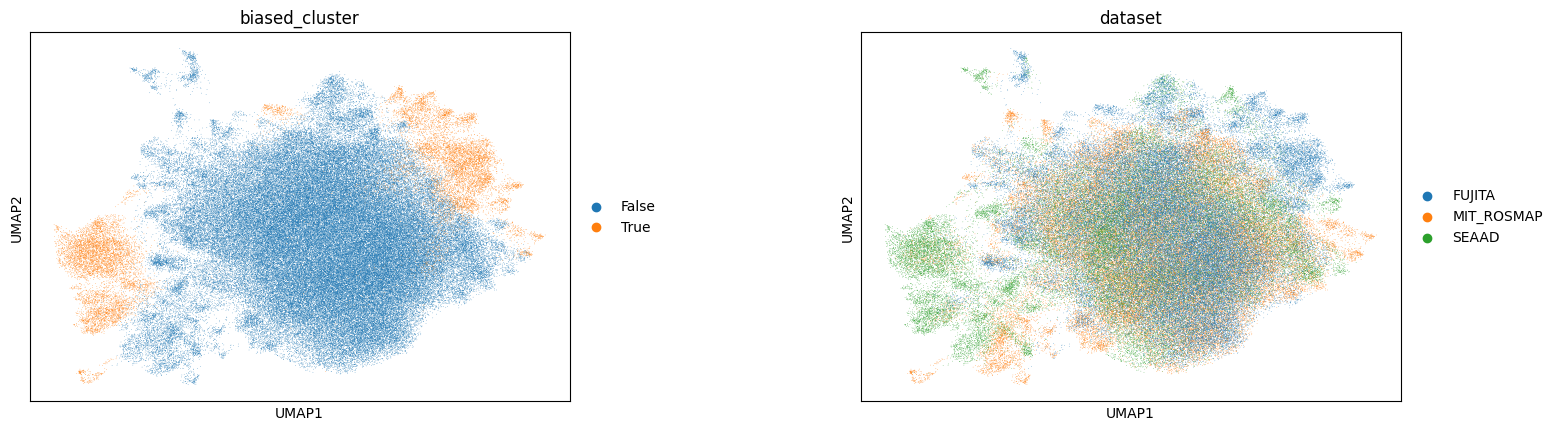

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ct = pd.crosstab(adata.obs["leiden_scvi"], adata.obs["dataset"], normalize="index") * 100

plt.figure(figsize=(8, 5))
sns.heatmap(ct, annot=True, fmt=".1f", cmap="Blues")
plt.title("Dataset composition per cluster (%)")
plt.xlabel("Dataset")
plt.ylabel("Leiden cluster")
plt.tight_layout()
plt.show()

biased_clusters = ct[(ct.max(axis=1) > 70)].index.tolist()  # clusters >70% from one dataset
print("Dataset-biased clusters:", biased_clusters)

adata.obs["biased_cluster"] = adata.obs["leiden_scvi"].isin(biased_clusters)
sc.pl.umap(adata, color=["biased_cluster", "dataset"], wspace=0.4)


/tmp/ipykernel_26126/684858021.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for cl, sub in adata.obs.groupby("leiden_scvi"):


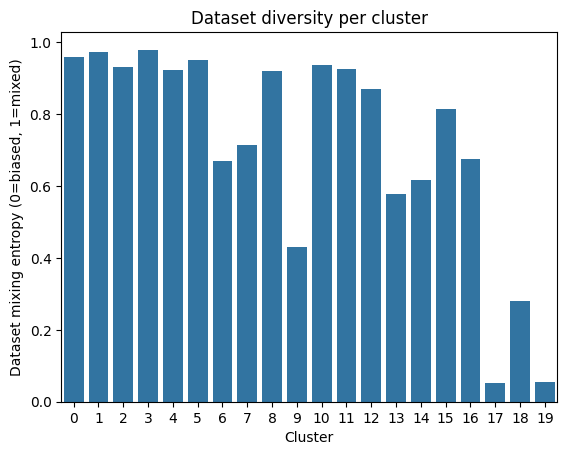

In [23]:
from scipy.stats import entropy

entropy_per_cluster = []
for cl, sub in adata.obs.groupby("leiden_scvi"):
    counts = sub["dataset"].value_counts(normalize=True)
    ent = entropy(counts) / np.log(len(counts))  # normalized [0,1]
    entropy_per_cluster.append((cl, ent))

entropy_df = pd.DataFrame(entropy_per_cluster, columns=["cluster", "normalized_entropy"]).set_index("cluster")

sns.barplot(x=entropy_df.index, y="normalized_entropy", data=entropy_df)
plt.ylabel("Dataset mixing entropy (0=biased, 1=mixed)")
plt.xlabel("Cluster")
plt.title("Dataset diversity per cluster")
plt.show()


In [24]:
# 2. Covariates to visualize
meta_vars = ["pct_counts_mt", "pct_counts_rb", "sex", "age_death", "cogdx", "dataset", "braak_label", "cerad_score_1_4", "apoe_genotype_std" ]
meta_vars = [v for v in meta_vars if v in adata.obs.columns]
print("🖼️ Covariates found:", meta_vars)

# ------------------------------------------------------------
# 3. Plot each covariate + Leiden side-by-side
# ------------------------------------------------------------
for cov in meta_vars:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # --- Left: covariate ---
    sc.pl.umap(
        adata,
        color=cov,
        ax=axes[0],
        show=False,
        color_map="viridis",
        na_color="lightgrey",
        title=f"{cov}",
        size=8,
    )
    
    # --- Right: Leiden clusters ---
    sc.pl.umap(
        adata,
        color="leiden_scvi",
        ax=axes[1],
        show=False,
        legend_loc="on data",
        title="Leiden clusters",
        palette="tab20",
        size=8,
    )
    
    plt.tight_layout()
    plt.savefig(f"umap_{cov}_vs_leiden.png", dpi=300, bbox_inches="tight")
    plt.close(fig)

print("✅ Saved all covariate + Leiden comparison UMAPs")


import os
# ------------------------------------------------------------
# 3. Create one UMAP per dataset, colored by Leiden cluster
# ------------------------------------------------------------
datasets = adata.obs["dataset"].unique().tolist()
outdir = "umaps_by_dataset"
os.makedirs(outdir, exist_ok=True)

for ds in datasets:
    adata_sub = adata[adata.obs["dataset"] == ds].copy()
    print(f"Plotting dataset: {ds} ({adata_sub.n_obs} cells)")

    fig = sc.pl.umap(
        adata_sub,
        color="leiden_scvi",
        palette="tab20",
        size=15,
        title=f"Dataset: {ds}",
        legend_loc="on data",
        show=False,
        frameon=False,
    )
    plt.savefig(os.path.join(outdir, f"umap_{ds}_by_cluster.png"),
                dpi=300, bbox_inches="tight")
    plt.close()

print(f"✅ Saved one UMAP per dataset in folder: {outdir}")

# ------------------------------------------------------------
# 4. (Optional) Grid plot of all datasets together
# ------------------------------------------------------------
ncols = 3
nrows = int(np.ceil(len(datasets) / ncols))
fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))

for i, ds in enumerate(datasets):
    ax = axes.flatten()[i]
    adata_sub = adata[adata.obs["dataset"] == ds].copy()
    sc.pl.umap(
        adata_sub,
        color="leiden_scvi",
        palette="tab20",
        size=10,
        title=ds,
        legend_loc=None,
        show=False,
        ax=ax,
        frameon=False,
    )

# hide empty subplots if any
for j in range(i+1, len(axes.flatten())):
    axes.flatten()[j].axis("off")

plt.tight_layout()
plt.savefig("umap_by_dataset_grid.png", dpi=300, bbox_inches="tight")
plt.close()
print("✅ Saved grid figure: umap_by_dataset_grid.png")


🖼️ Covariates found: ['pct_counts_mt', 'sex', 'age_death', 'cogdx', 'dataset', 'braak_label', 'cerad_score_1_4', 'apoe_genotype_std']
✅ Saved all covariate + Leiden comparison UMAPs
Plotting dataset: MIT_ROSMAP (57452 cells)
Plotting dataset: SEAAD (38103 cells)
Plotting dataset: FUJITA (58593 cells)
✅ Saved one UMAP per dataset in folder: umaps_by_dataset
✅ Saved grid figure: umap_by_dataset_grid.png


In [30]:
import os
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  # ✅ needed for dtype checking

# ------------------------------------------------------------
# 1. Define metadata columns you want to visualize
# ------------------------------------------------------------
color_vars = [
    "AD_status",
    "pct_counts_mt",
    "sex",
    "cerad_score_1_4",
    "age_death",
    "braak_label",
    "apoe_genotype_std"
]

# Only keep those that actually exist in adata.obs
color_vars = [c for c in color_vars if c in adata.obs.columns]
print("🎨 Variables to plot:", color_vars)

# ------------------------------------------------------------
# 2. Create output directory
# ------------------------------------------------------------
outdir = "umaps_by_dataset_and_variable"
os.makedirs(outdir, exist_ok=True)

# ------------------------------------------------------------
# 3. Loop through datasets and variables
# ------------------------------------------------------------
datasets = adata.obs["dataset"].unique().tolist()

for ds in datasets:
    adata_sub = adata[adata.obs["dataset"] == ds].copy()
    print(f"\n📊 Dataset: {ds} ({adata_sub.n_obs} cells)")

    for var in color_vars:
        print(f"  → Plotting by {var}")

        # ✅ Determine colormap type safely
        if pd.api.types.is_numeric_dtype(adata_sub.obs[var]):
            cmap = "viridis"
        else:
            cmap = "tab20"

        # Prepare figure
        fig = sc.pl.umap(
            adata_sub,
            color=var,
            size=15,
            title=f"{ds} — {var}",
            cmap=cmap,
            show=False,
            frameon=False,
        )

        # Save plot
        safe_var = var.replace("/", "_").replace(" ", "_")
        outfile = os.path.join(outdir, f"umap_{ds}_{safe_var}.png")
        plt.savefig(outfile, dpi=300, bbox_inches="tight")
        plt.close()

print(f"\n✅ Saved all UMAPs separated by dataset in folder: {outdir}")

# ------------------------------------------------------------
# 4. (Optional) Grid per-variable across all datasets
# ------------------------------------------------------------
ncols = 3
for var in color_vars:
    nrows = int(np.ceil(len(datasets) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))
    axes = axes.flatten()

    for i, ds in enumerate(datasets):
        adata_sub = adata[adata.obs["dataset"] == ds].copy()
        if pd.api.types.is_numeric_dtype(adata_sub.obs[var]):
            cmap = "viridis"
        else:
            cmap = "tab20"

        sc.pl.umap(
            adata_sub,
            color=var,
            size=10,
            title=ds,
            cmap=cmap,
            legend_loc=None,
            show=False,
            ax=axes[i],
            frameon=False,
        )

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.savefig(os.path.join(outdir, f"umap_grid_{var}.png"),
                dpi=300, bbox_inches="tight")
    plt.close()

print("✅ Saved grid figures for each variable (e.g., umap_grid_AD_status.png, etc.)")


🎨 Variables to plot: ['AD_status', 'pct_counts_mt', 'sex', 'cerad_score_1_4', 'age_death', 'braak_label', 'apoe_genotype_std']

📊 Dataset: MIT_ROSMAP (57452 cells)
  → Plotting by AD_status
  → Plotting by pct_counts_mt
  → Plotting by sex
  → Plotting by cerad_score_1_4
  → Plotting by age_death
  → Plotting by braak_label
  → Plotting by apoe_genotype_std

📊 Dataset: SEAAD (38103 cells)
  → Plotting by AD_status
  → Plotting by pct_counts_mt
  → Plotting by sex
  → Plotting by cerad_score_1_4
  → Plotting by age_death
  → Plotting by braak_label
  → Plotting by apoe_genotype_std

📊 Dataset: FUJITA (58593 cells)
  → Plotting by AD_status
  → Plotting by pct_counts_mt
  → Plotting by sex
  → Plotting by cerad_score_1_4
  → Plotting by age_death
  → Plotting by braak_label
  → Plotting by apoe_genotype_std

✅ Saved all UMAPs separated by dataset in folder: umaps_by_dataset_and_variable
✅ Saved grid figures for each variable (e.g., umap_grid_AD_status.png, etc.)


In [26]:
# ------------------------------------------------------------
# 2. Prepare covariates
# ------------------------------------------------------------
covariates = [ "total_counts",
    "pct_counts_mt", "sex", "age_death", "cogdx",
    "dataset", "braak_label", "cerad_score_1_4", "apoe_genotype_std"
]
covariates = [c for c in covariates if c in adata.obs.columns]
print("🔍 Covariates found:", covariates)

# ------------------------------------------------------------
# 3. Compute per-cell correlation proxies
# ------------------------------------------------------------
# Convert cluster to dummy variables (one-hot encoding)
cluster_dummies = pd.get_dummies(adata.obs["leiden_scvi"], prefix="cluster").astype(int)

# Create combined dataframe for correlation analysis
df = pd.concat([cluster_dummies, adata.obs[covariates].copy()], axis=1)

# Encode categorical covariates as integers
for cov in covariates:
    if df[cov].dtype.name == "category" or df[cov].dtype == object:
        df[cov] = df[cov].astype("category").cat.codes

# ------------------------------------------------------------
# 4. Define helper: Cramer's V for categorical covariates
# ------------------------------------------------------------
def cramers_v(x, y):
    """Compute Cramer's V (effect size for categorical association)."""
    confusion = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion)[0]
    n = confusion.sum().sum()
    phi2 = chi2 / n
    r, k = confusion.shape
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1)) / (n - 1))
    rcorr = r - ((r - 1)**2) / (n - 1)
    kcorr = k - ((k - 1)**2) / (n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# ------------------------------------------------------------
# 5. Compute correlations (Spearman for numeric, Cramer's V for categorical)
# ------------------------------------------------------------
corr_matrix = pd.DataFrame(index=cluster_dummies.columns, columns=covariates, dtype=float)

for cov in covariates:
    col = df[cov]
    if pd.api.types.is_numeric_dtype(col):
        # Spearman correlation per cluster dummy
        for cluster_col in cluster_dummies.columns:
            rho, _ = spearmanr(df[cluster_col], col)
            corr_matrix.loc[cluster_col, cov] = rho
    else:
        # Cramer's V for categorical covariates
        for cluster_col in cluster_dummies.columns:
            corr_matrix.loc[cluster_col, cov] = cramers_v(df[cluster_col], col)

corr_matrix = corr_matrix.astype(float)

# ------------------------------------------------------------
# 6. Visualize correlation matrix
# ------------------------------------------------------------
plt.figure(figsize=(12, 6))
sns.heatmap(
    corr_matrix,
    cmap="vlag",
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.3,
    cbar_kws={"label": "Correlation (Spearman or Cramér's V)"}
)
plt.title("Correlation of Leiden clusters with covariates")
plt.xlabel("Covariates")
plt.ylabel("Leiden cluster")
plt.tight_layout()
plt.savefig("cluster_covariate_correlation_heatmap.png", dpi=300, bbox_inches="tight")
plt.close()

print("✅ Saved: cluster_covariate_correlation_heatmap.png")

plt.figure(figsize=(12, 6))
sns.heatmap(
    corr_matrix,
    cmap="vlag",
    center=0,
    annot=True,
    fmt=".2f",
    linewidths=0.3,
    cbar_kws={"label": "Correlation (Spearman or Cramér's V)"}
)
plt.title("Correlation of Leiden clusters with covariates")
plt.xlabel("Covariates")
plt.ylabel("Leiden cluster")

# ✅ Rotate column (x-axis) labels
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig("cluster_covariate_correlation_heatmap_rotated.png", dpi=300, bbox_inches="tight")
plt.close()

print("✅ Saved: cluster_covariate_correlation_heatmap_rotated.png")



🔍 Covariates found: ['total_counts', 'pct_counts_mt', 'sex', 'age_death', 'cogdx', 'dataset', 'braak_label', 'cerad_score_1_4', 'apoe_genotype_std']
✅ Saved: cluster_covariate_correlation_heatmap.png
✅ Saved: cluster_covariate_correlation_heatmap_rotated.png
